In [31]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import blueice as bi
from multihist import Histdd, Hist1d
import pandas as pd
import scipy

## Pulse simulation

In [2]:
def simulate_photon_times(n_photons, t1, t3, fs, tts):
    n_photons = int(n_photons)
    times = np.zeros(n_photons)
    n_singlets = np.random.binomial(n=n_photons, p=fs)
    times += np.concatenate([
        np.random.exponential(t1, n_singlets),
        np.random.exponential(t3, n_photons - n_singlets)
    ])
    np.random.shuffle(times)
    times += np.random.normal(0, tts, size=n_photons)
    return times

In [3]:
def build_likelihood_function(n_photons, t1, t3, fs, tts, hist_range, hist_bins, 
                              offset = None, plot=False, ):
    if offset is None:
        offset = 1 / n_photons
    times = simulate_photon_times(n_photons, t1, t3, fs, tts)
    vals, edges  = np.histogram(times, range = hist_range, bins = hist_bins, normed=True)
    vals = np.max([vals, np.ones(len(vals)) * offset], axis=0)
    centers = 0.5 * (edges[:-1] + edges[1:])
    def f(x):
        return np.interp(x, centers, vals)
    def negloglikelihood(x):
        return np.interp(x, centers, -np.log(vals))
    
    if plot:
        x_plot = centers
        plt.hist(times, range = hist_range, bins = hist_bins, normed=True, histtype = 'step')
        plt.plot(centers, f(centers))
        plt.yscale('log')
    return negloglikelihood

In [4]:
# def simulate_s1_times(n_photons, t1, t3, fs, tts, photons_per_s1):
#     times = simulate_photon_times(n_photons, t1, t3, fs, tts)
#     n_s1s = int(np.floor(n_photons / photons_per_s1))
#     times = times[:(n_s1s * photons_per_s1)]
#     s1_times = np.split(times, n_s1s)
#     return np.array(s1_times)

In [5]:
from tqdm import tqdm
def max_likelihood(s1, f):
    '''
    Minimize the value of the sum of the negative sum likelikhood given an array of times by shifting it 
    by a constant value in time.
    Returns (sum neg log likelihood, shift)
    '''
    optres = scipy.optimize.minimize(lambda x: np.sum(f(s1 + x)), 0.)
    shift = optres.x[0]
    like  = optres.fun
    return like, shift

In [6]:
def likelihood_ratio(s1, f_er, f_nr):
    er_likelihood = max_likelihood(s1, f_er)
    nr_likelihood = max_likelihood(s1, f_nr)
    # LR = np.array(nr_likelihood[0]) / np.array(er_likelihood[0])
    LR = nr_likelihood[0] - er_likelihood[0]
    return LR

## Dataset processing

In [16]:
def add_props(df, band):
    df['band'] = band
    # We do not divide by 1.15, already done in simulation
    g1 =  0.1442 
    g2 = 11.52 
    df['e_rec'] = 13.7e-3 * ((df['cs1'] / g1) + (df['cs2'] / g2))
    return 

In [205]:
def get_fit_values(E, band, X, field='low', tts= None):
    '''
    Extract the fit values for specific energies.
    Returns a dict containing key values for that energy, interpolated!
    If `return_tts`, will include tts as key.
    '''
    # Select fit values that are relevant
    if field == 'high':
        if band == 'er':
            x = X[0]
        elif band == 'nr':
            x = X[1]
    if field == 'low':
        if band == 'er':
            x = X[2]
        elif band == 'nr':
            x = X[3]
    
    es = x['e'] # energy list for the fit points
    ret = {}
    if not tts:
        keys = ['t3', 'fs', 't1', 'tts']
    else:
        keys = ['t3', 'fs', 't1']
    # Loop over keys and interpolate between values.    
    for key in keys:
        ret[key] = np.interp(E, es, x[key])
    if tts:
        ret['tts'] = tts
        
    return ret

In [41]:
def get_lr(el, F_er, F_nr):
    '''
    Simulate the shape of a pulse and return this value
    '''
    # We take the reconstructed energy: it must be valid for both ER and NR!
    E = el['e_rec']
    if E > 20:
        print('Warning: energy %.1f out of range, replacing with 20 keV...' % (E))
        E = 20.
    
    # We have bins of 1 keV (seems sufficient) so round and pull the likelihood function from the database
    f_er = F_er[int(round(E))]
    f_nr = F_nr[int(round(E))]
    
    # Now simulate the shape given the reconstructed energy
    s1 = simulate_photon_times(el['s1_photons_detected'], **get_fit_values(E, el['band'], X))
    # Get likelihood
    lr = likelihood_ratio(s1, f_er, f_nr)
    return lr

In [ ]:
def add_lr(df, F_er, F_nr, print_every = int(1e4)):
    '''
    Add the likelihood ratio to all events in dataframe.
    '''
    lrs = []
    for i, el in df.iterrows():
        lrs.append(get_lr(el, F_er, F_nr))
        if i % print_every == 0:
            print('%d of %d done, %.1f %%...' % (i, len(df), i / len(df) * 100))
    df['lr'] = lrs
    return

In [219]:
def produce_likelihood_library(start, stop, field, X, tts = None, n_photons = int(1e7),
                               hist_range = (-50, 250), hist_bins = 1000):
    '''
    Produce the likelihoods per keV, for both ER and NR. 
    '''
    num = (stop - start + 1)
    F_er = np.array([
        build_likelihood_function(int(1e7), hist_range = (-50, 250), hist_bins = 1000,
                                **get_fit_values(energy, 'er', X, field = field, tts = tts)) 
                                for energy in np.linspace(start, stop, num)])
    F_nr = np.array([
        build_likelihood_function(int(1e7), hist_range = (-50, 250), hist_bins = 1000,
                                **get_fit_values(energy, 'nr', X, field = field, tts = tts)) 
                                for energy in np.linspace(start, stop, num)])
    return F_er, F_nr

## Make datasets

In [7]:
# Get base model
# If this is the first time you run it, it will take a few minutes
from laidbax import base_model
model = bi.Model(base_model.config)

In [102]:
wimp = pd.DataFrame(wimpsource.simulate(40000))

In [101]:
er = pd.DataFrame(ersource.simulate(40000))

In [103]:
add_props(er, 'er')
add_props(wimp, 'nr')

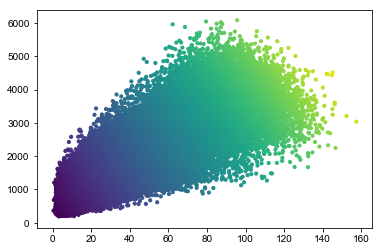

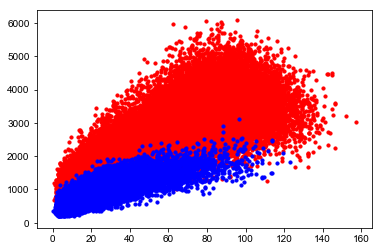

In [104]:
for df in [er, wimp]:
    plt.scatter(df['cs1'], df['cs2'], c=df['e_rec'], vmax=20, s=10)
plt.show()

for df, c in zip([er, wimp], ['red', 'blue']):
    plt.scatter(df['cs1'], df['cs2'], c=c, s=10)


## Adding LRs

Read the fit values. Not that this currently includes the tts as a floating fit parameter, maybe you want to change later?

In [208]:
X = pickle.load(open('../X.pickle', 'rb')) # Contains fit values
Y = pickle.load(open('../Y.pickle', 'rb')) # Fits with tts fixed at 1.5

### Example for one event

In [25]:
el = er.iloc[0]

In [26]:
ts = simulate_photon_times(el['s1_photons_detected'], **get_fit_values(el['energy'], 'er', X))

In [27]:
f_er = build_likelihood_function(int(1e7), hist_range = (-50, 250), hist_bins = 1000,
                                 **get_fit_values(el['energy'], 'er', X))
f_nr = build_likelihood_function(int(1e7), hist_range = (-50, 250), hist_bins = 1000,
                                 **get_fit_values(el['energy'], 'nr', X))

(-10, 100)

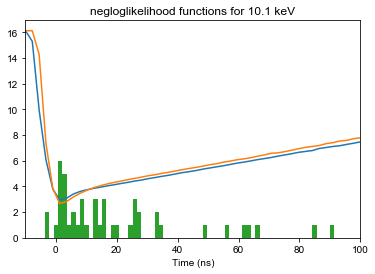

In [29]:
x_plot = np.linspace(-10, 100)
plt.plot(x_plot, f_er(x_plot))
plt.plot(x_plot, f_nr(x_plot))
plt.hist(ts, bins=100)
plt.xlabel('Time (ns)')
plt.title('negloglikelihood functions for %.1f keV' % (el['energy']))
plt.xlim(-10, 100)

In [32]:
likelihood_ratio(ts, f_er, f_nr)

2.7229569296434306

## Adding it for all events

### Likelihood library

These are libraries of likelihood functions as a function of reconstructed energy!

In [209]:
F_er, F_nr = produce_likelihood_library(0, 20, 'low', Y, tts = 1.5, n_photons=int(1e7), 
                                        hist_range = (-50, 250), hist_bins = 1000)

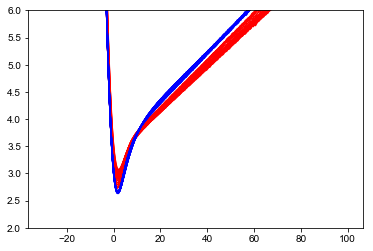

In [217]:
_x = np.linspace(-30, 100, 400)
for f in F_er:
    plt.plot(_x, f(_x), color='red')
for f in F_nr:
    plt.plot(_x, f(_x), color='blue')

plt.ylim(2, 6)
plt.show()

In [211]:
F_er_10, F_nr_10 = produce_likelihood_library(0, 20, 'low', Y, tts = 10, n_photons=int(1e7), 
                                        hist_range = (-50, 250), hist_bins = 1000)

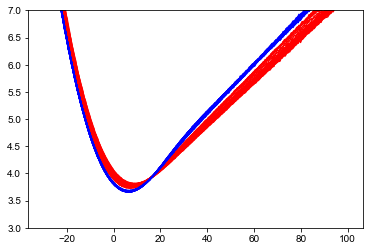

In [216]:
_x = np.linspace(-30, 100, 400)
for f in F_er_10:
    plt.plot(_x, f(_x), color='red')
for f in F_nr_10:
    plt.plot(_x, f(_x), color='blue')

plt.ylim(3, 7)
plt.show()

## Process events

In [106]:
add_lr(er, F_er, F_nr, print_every=2000)

0 of 35925 done, 0.0 %...
2000 of 35925 done, 5.6 %...


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


4000 of 35925 done, 11.1 %...
6000 of 35925 done, 16.7 %...


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


8000 of 35925 done, 22.3 %...
10000 of 35925 done, 27.8 %...
12000 of 35925 done, 33.4 %...
14000 of 35925 done, 39.0 %...
16000 of 35925 done, 44.5 %...
18000 of 35925 done, 50.1 %...
20000 of 35925 done, 55.7 %...


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


22000 of 35925 done, 61.2 %...
24000 of 35925 done, 66.8 %...
26000 of 35925 done, 72.4 %...
28000 of 35925 done, 77.9 %...
30000 of 35925 done, 83.5 %...
32000 of 35925 done, 89.1 %...
34000 of 35925 done, 94.6 %...


In [107]:
add_lr(wimp, F_er, F_nr, print_every=2000)

0 of 22712 done, 0.0 %...
2000 of 22712 done, 8.8 %...


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


4000 of 22712 done, 17.6 %...
6000 of 22712 done, 26.4 %...
8000 of 22712 done, 35.2 %...


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


10000 of 22712 done, 44.0 %...
12000 of 22712 done, 52.8 %...
14000 of 22712 done, 61.6 %...
16000 of 22712 done, 70.4 %...


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


18000 of 22712 done, 79.3 %...
20000 of 22712 done, 88.1 %...


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


22000 of 22712 done, 96.9 %...


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


## Build the histogram

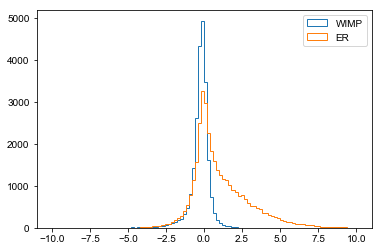

In [116]:
plt.hist(wimp['lr'], bins=100, histtype='step', range=(-10, 10), label='WIMP')
plt.hist(er['lr'], bins=100, histtype='step', range=(-10, 10), label='ER')
plt.legend()
plt.show()

In [117]:
m_er = Histdd(bins=30, range=((-10, 10), (0, 150), (0, 6000)), axis_names = ['lr', 'cs1', 'cs2'])

In [118]:
m_er.add(er['lr'], er['cs1'], er['cs2'])

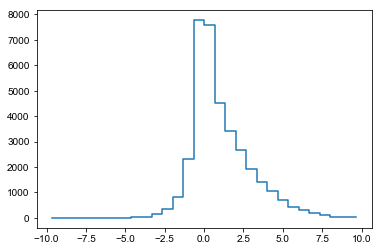

In [119]:
m_er.projection('lr').plot()

In [120]:
m_wimp = Histdd(bins=30, range=((-10, 10), (0, 150), (0, 6000)), axis_names = ['lr', 'cs1', 'cs2'])
m_wimp.add(wimp['lr'], wimp['cs1'], wimp['cs2'])

In [141]:
offset  = 0
fom = (m_wimp + offset) / (m_er + offset) 
fom.histogram = np.log10(fom.histogram)


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: divide by zero encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: invalid value encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [142]:
mask = ~np.isnan(fom.histogram)

(0, 2000)

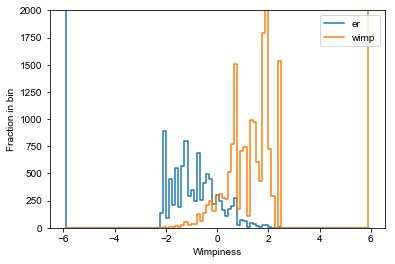

In [143]:
bounds = (-6, 6)
bins = np.linspace(*bounds, num=100)
hists = dict()
for label, q in ('er', m_er), ('wimp', m_wimp):
    hists[label] = h = Hist1d(
        # Clip values to fall inside bins
        np.clip(fom.histogram[mask], bounds[0], bounds[-1] - 1e-7),
        weights=q.histogram[mask],
        bins=bins
    )
    h.plot(label=label)
plt.legend(loc='upper right')
plt.xlabel("Wimpiness")
plt.ylabel("Fraction in bin")
plt.ylim(0, 2000)

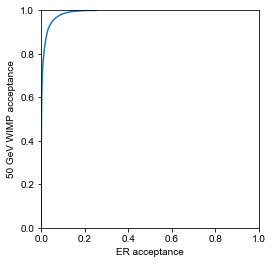

In [145]:
plt.plot(1 - hists['er'].cumulative_density,
         1 - hists['wimp'].cumulative_density, label='Including PSD')
plt.xlabel("ER acceptance")
plt.ylabel("50 GeV WIMP acceptance")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect(1)

In [161]:
def get_ROC(er, wimp, bins=30, range=((-10, 10), (0, 150), (0, 6000)), axis_names = ['lr', 'cs1', 'cs2']):
    m_wimp = Histdd(bins = bins, range=range, axis_names=axis_names)
    m_wimp.add(*[wimp[key] for key in axis_names])
    
    m_er = Histdd(bins = bins, range=range, axis_names=axis_names)
    m_er.add(*[er[key] for key in axis_names])
    
    offset  = 0
    fom = (m_wimp + offset) / (m_er + offset) 
    fom.histogram = np.log10(fom.histogram)
    mask = ~np.isnan(fom.histogram)
    
    
    bounds = (-6, 6)
    bins = np.linspace(*bounds, num=100)
    hists = dict()
    for label, q in ('er', m_er), ('wimp', m_wimp):
        hists[label] = h = Hist1d(
            # Clip values to fall inside bins
            np.clip(fom.histogram[mask], bounds[0], bounds[-1] - 1e-7),
            weights=q.histogram[mask],
            bins=bins
        )
        h.plot(label=label)
    plt.legend(loc='upper right')
    plt.xlabel("Wimpiness")
    plt.ylabel("Fraction in bin")
    plt.ylim(0, 2000)
    plt.show()
    
    plt.plot(1 - hists['er'].cumulative_density,
         1 - hists['wimp'].cumulative_density, label='Including PSD')
    plt.xlabel("ER acceptance")
    plt.ylabel("50 GeV WIMP acceptance")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect(1)
    plt.show()
    return hists

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: divide by zero encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: invalid value encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


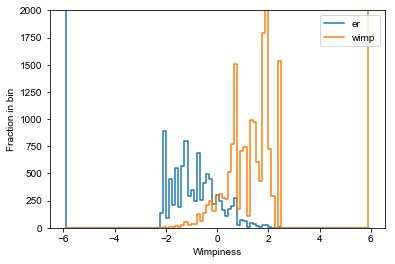

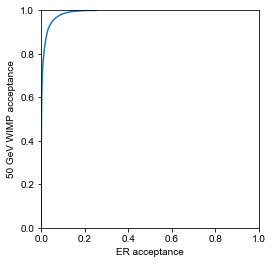

In [163]:
hists = get_ROC(er, wimp)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: divide by zero encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: invalid value encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


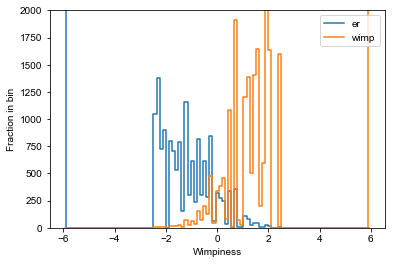

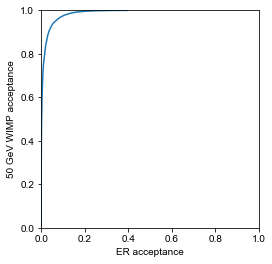

In [164]:
hists2 = get_ROC(er, wimp, bins=30, range=((0, 150), (0, 6000)), axis_names = ['cs1', 'cs2'])

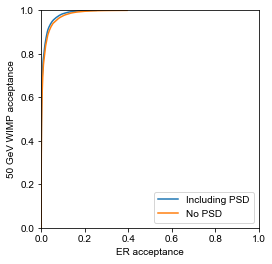

In [171]:
plt.plot(1 - hists['er'].cumulative_density,
     1 - hists['wimp'].cumulative_density, label='Including PSD')
plt.plot(1 - hists2['er'].cumulative_density,
     1 - hists2['wimp'].cumulative_density, label='No PSD')
plt.xlabel("ER acceptance")
plt.ylabel("50 GeV WIMP acceptance")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect(1)
plt.legend(loc='lower right')
plt.show()

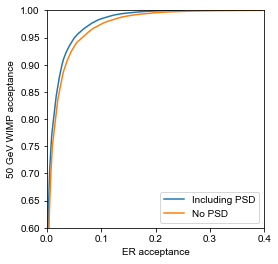

In [175]:
plt.plot(1 - hists['er'].cumulative_density,
     1 - hists['wimp'].cumulative_density, label='Including PSD')
plt.plot(1 - hists2['er'].cumulative_density,
     1 - hists2['wimp'].cumulative_density, label='No PSD')
plt.xlabel("ER acceptance")
plt.ylabel("50 GeV WIMP acceptance")
plt.xlim(0, 0.4)
plt.ylim(0.6, 1)
plt.gca().set_aspect(1)
plt.legend(loc='lower right')
plt.show()

In [185]:
def get_ROC_1D(er, wimp, bins=30, range = (-10, 10), axis_name = 'lr'):
    m_er = Hist1d(er[axis_name], bins=bins, range=range)
    m_wimp = Hist1d(wimp[axis_name], bins=bins, range=range)
    
    offset = 0
    fom = (m_wimp + offset) / (m_er + offset) 
    fom.histogram = np.log10(fom.histogram)
    mask = ~np.isnan(fom.histogram)
    
    bounds = (-6, 6)
    bins = np.linspace(*bounds, num=100)
    hists = dict()
    for label, q in ('er', m_er), ('wimp', m_wimp):
        hists[label] = h = Hist1d(
            # Clip values to fall inside bins
            np.clip(fom.histogram[mask], bounds[0], bounds[-1] - 1e-7),
            weights=q.histogram[mask],
            bins=bins
        )
        h.plot(label=label)
    plt.legend(loc='upper right')
    plt.xlabel("Wimpiness")
    plt.ylabel("Fraction in bin")
    
    plt.show()
    
    plt.plot(1 - hists['er'].cumulative_density,
         1 - hists['wimp'].cumulative_density, label='Including PSD')
    plt.xlabel("ER acceptance")
    plt.ylabel("50 GeV WIMP acceptance")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect(1)
    plt.show()
    return hists

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: divide by zero encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: invalid value encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


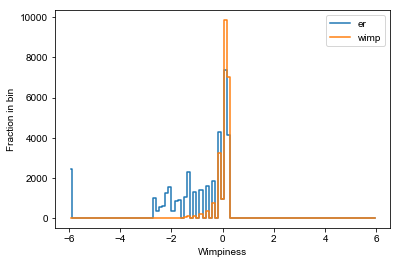

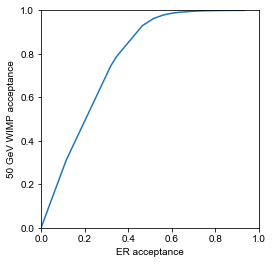

In [188]:

hist3 = get_ROC_1D(er, wimp, bins=100)

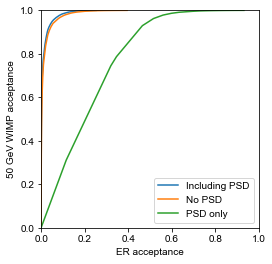

In [191]:
plt.plot(1 - hists['er'].cumulative_density,
     1 - hists['wimp'].cumulative_density, label='Including PSD')
plt.plot(1 - hists2['er'].cumulative_density,
     1 - hists2['wimp'].cumulative_density, label='No PSD')
plt.plot(1 - hist3['er'].cumulative_density,
     1 - hist3['wimp'].cumulative_density, label='PSD only')
plt.xlabel("ER acceptance")
plt.ylabel("50 GeV WIMP acceptance")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect(1)
plt.legend(loc='lower right')
plt.show()

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/axes/_base.py:1404: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))


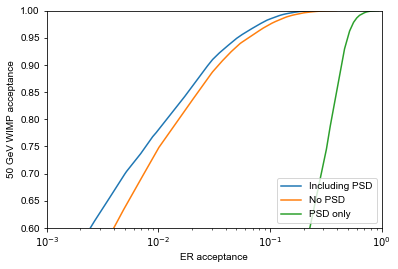

In [197]:
plt.plot(1 - hists['er'].cumulative_density,
     1 - hists['wimp'].cumulative_density, label='Including PSD')
plt.plot(1 - hists2['er'].cumulative_density,
     1 - hists2['wimp'].cumulative_density, label='No PSD')
plt.plot(1 - hist3['er'].cumulative_density,
     1 - hist3['wimp'].cumulative_density, label='PSD only')
plt.xlabel("ER acceptance")
plt.ylabel("50 GeV WIMP acceptance")
plt.xscale('log')
plt.xlim(1e-3, 1)
plt.ylim(0.6, 1)
plt.gca().set_aspect(1)
plt.legend(loc='lower right')
plt.show()